This notebook includes:



1)the WLS analysis of particulate and dissolved Pa, 


2)the F-statistic 

3)and the map.

In [155]:
import numpy as np
import math,os,glob
import pandas as pd
from pylab import *
from netCDF4 import Dataset
import pylab as pl
from mpl_toolkits.basemap import Basemap,shiftgrid,cm
import matplotlib.cm as cm
from scipy.stats import f as scist

import numpy
import matplotlib.pyplot as plt
import statsmodels.api as sm
% matplotlib inline

nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/findk/All_Arctic-data/WLS/Pa/*.csv'))
print len(nc_filename)
print("found *.csv file: \n{}".format(nc_filename))

7
found *.csv file: 
['/ocean/xiaoxiny/research/findk/All_Arctic-data/WLS/Pa/60changed.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/findk/All_Arctic-data/WLS/Pa/60changed2.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/findk/All_Arctic-data/WLS/Pa/60changed3.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/findk/All_Arctic-data/WLS/Pa/60changed4.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/findk/All_Arctic-data/WLS/Pa/60changed6.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/findk/All_Arctic-data/WLS/Pa/IC_32_1.csv', '/ocean/xiaoxiny/research/findk/All_Arctic-data/WLS/Pa/abondant_60changed5.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv']


#Fitting the part. Pa

In [156]:
file_num=5
marker=['D','s','s','s','s','s','s']

WLS_err1=np.empty([file_num,1])
WLS_coef1=np.empty([file_num,1])
WLS_errc=np.empty([file_num,1])
WLS_coefc=np.empty([file_num,1])
sinking_rate=np.empty([file_num,1])

rss1=np.empty([file_num,1])
rss2=np.empty([file_num,1])


1991 ARCTIC EXPEDITION Stn1
df:(1,3)
ftest:0.0421626548286
sinking   :1.680169e+03,error:6.636161e+02

1991 ARCTIC EXPEDITION Stn2
df:(1,2)
ftest:0.334106198713
sinking   :1.131083e+03,error:4.857082e+02

1991 ARCTIC EXPEDITION Stn3
df:(1,4)
ftest:0.00127291263109
sinking   :1.100871e+03,error:2.248592e+02

1991 ARCTIC EXPEDITION Stn4
df:(1,3)
ftest:0.0218233788616
sinking   :1.768761e+03,error:6.178108e+02

1991 ARCTIC EXPEDITION Stn6
df:(1,4)
ftest:0.0784215379826
sinking   :7.128161e+02,error:2.298111e+02


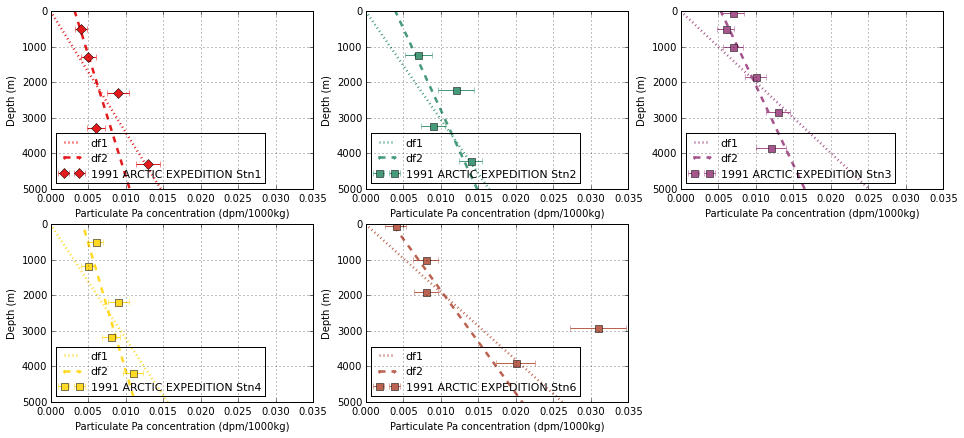

In [157]:
#ax = plt.figure(1,figsize=(10,7))
for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    
    y= data['depth'];
    name= data['name'][0];
    x=data['231Pa part.'];
    lon = data['long.'];
    lat = data['lat.'];
    err =data['Pa_part_err']
    
    x=np.ma.masked_where(x<=0,x)
    y=np.ma.masked_where(x<=0,y)
    err=np.ma.masked_where(x<=0,err)
    
    x=np.ma.masked_where(x<=0,x)
    y=np.ma.masked_where(x<=0,y)
    err=np.ma.masked_where(x<=0,err)
    x=x.compressed()
    y=y.compressed()
    err=err.compressed()
    
    y2 = sm.add_constant(y,prepend=False)
    #y2=y
    res_wls = sm.WLS(x, y2, weights=1./err**4).fit()
    
    ftest=sm.WLS(x, y, weights=1./err**4).fit()


    model1=np.sum(ftest.resid**2/err**4)
    model2=np.sum(res_wls.resid**2/err**4)
    rss1[j]=model1
    rss2[j]=model2
    
    p1 = 1
    p2 = 2
    n = len(x)
    #F = (ftest.mse_resid - res_wls.mse_resid)/(res_wls.mse_resid) *(n-p2)/(p2-p1)
    F = ( model1 - model2)/model2*(n-p2)/(p2-p1)
    p = 1.0 - scist.cdf(F,p2-p1,n-p2)
    
    WLS_err1[j,:] = res_wls.bse[0]
    WLS_coef1[j,:] = res_wls.params[0]
    #WLS_coefc[j,:]=res_wls.params[1]
    sinking_rate[j,:]=0.00246/res_wls.params[0]
    err1=(WLS_err1[j,:]/WLS_coef1[j,:])*1./WLS_coef1[j,:]*0.00246
    
    print ('')
    print (name)
    print ('df:(%s,%s)'%(p2-p1,n-p2))
    #print ('F ratio: %s'%F)
    print ('ftest:%s'%p)
    
    if F<=0:
        print ('df1 weighted resid. sum:%s'%model1)
        print ('df2 weighted resid. sum:%s'%model2)

    #print ('slope:%e,error:%e'%(res_wls.params[0],res_wls.bse[0]))
    #print ('C1   :%e,error:%e'%(res_wls.params[1],res_wls.bse[1]))
    print ('sinking   :%e,error:%e'%(sinking_rate[j,:],err1))


    #ax = plt.subplot()
    ax = plt.figure(1,figsize=(16,7))
    ax = plt.subplot(2,3,j+1)
    cc=cm.Set1(j*50)#Spectral(j*23)
    ax.plot([0, 0.3],[0, 0.3]/ftest.params[0], ':',c=cc,linewidth=2.5,label='df1')
    ax.plot([0, 0.3],[0, 0.3]/res_wls.params[0]-res_wls.params[1]/res_wls.params[0], '--.',c=cc,linewidth=2.5,label='df2')
    ax.errorbar(x, y,xerr=err, fmt=marker[j],markersize=7,c=cc,label=name)
    ax.legend(loc=3,fontsize=11)
    
    ax.set_ylim([0, 5000])
    ax.set_xlim([0, 0.035])
#    if j+1==1 or j+1==4:
    plt.ylabel('Depth (m)')
#    if j+1==5:
    plt.xlabel('Particulate Pa concentration (dpm/1000kg)')
#    if j+1==1 or j+1==2 or j+1==3:
#        plt.setp(ax.get_xticklabels(), visible=False)
#    if not (j+1==1 or j+1==4):
#        plt.setp(ax.get_yticklabels(), visible=False)
#    plt.subplots_adjust(wspace=.0000001, hspace=.0000001)

    plt.grid()
    plt.gca().invert_yaxis()
    #plt.tight_layout()
plt.show()

# total F-test

In [158]:
p1 = 1
p2 = 2
n = 26
F = (sum(rss1) - sum(rss2))/(sum(rss2)) *(n-p2*5)/(p2*5-p1*5)
p = 1.0 - scist.cdf(F,p2-p1,n-p2)
print ('df:(%s,%s)'%((p2-p1)*5,(n-p2*5)))
print ('F ratio: %s'%F)
print ('ftest:%s'%p)

df:(5,16)
F ratio: 15.9136064863
ftest:0.000541501903968


#Fitting the diss. Pa

####(1) Change into fit Q-C{1}K{-1}-K{-1}Qz/S (With inercepts)

In [159]:
WLS_err2=np.empty([file_num,1])
Kvalue=np.empty([file_num,1])
WLS_coef2=np.empty([file_num,1])


1991 ARCTIC EXPEDITION Stn1
K   :2.227339e-02,error:1.059110e-03

1991 ARCTIC EXPEDITION Stn2
K   :3.097313e-02,error:1.643706e-03

1991 ARCTIC EXPEDITION Stn3
K   :1.675560e-02,error:1.262348e-03

1991 ARCTIC EXPEDITION Stn4
K   :2.552325e-02,error:7.286429e-04

1991 ARCTIC EXPEDITION Stn6
K   :3.184943e-02,error:2.212332e-03


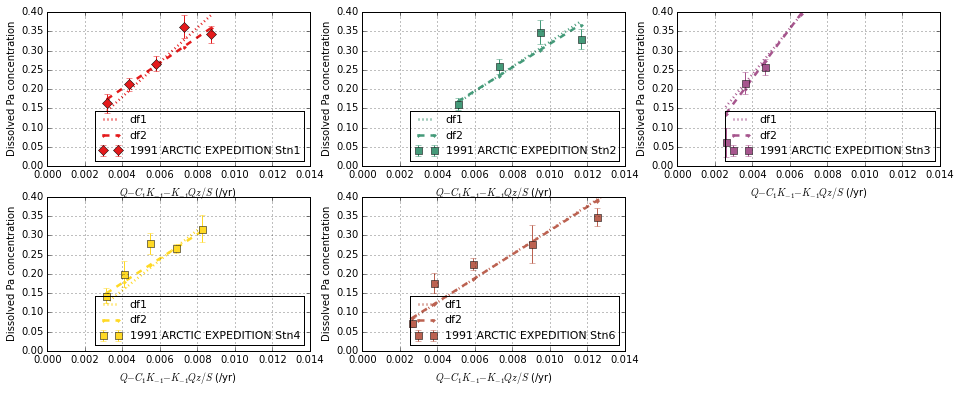

In [160]:
for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    
    y= data['depth'];
    x= data['231Pa diss.'];
    name= data['name'][0];
    lon = data['long.'];
    lat = data['lat.'];
    err =data['Pa_diss_err']
    x=np.ma.masked_where(x<=0,x)
    y=np.ma.masked_where(x<=0,y)
    err=np.ma.masked_where(x<=0,err)      
    x=x.compressed()
    y=y.compressed()
    err=err.compressed()
    
    y2=np.empty(len(x))
    for k in range (len(x)):
         y2[k]=(0.00246-WLS_coefc[j,:])+(WLS_coef1[j,:]*y[k])

    #fit: model2
    y3 = sm.add_constant(y2,prepend=False)  
    res_wls2 = sm.WLS(x,y3, weights=1./err**4).fit() 
    
    WLS_coef2[j]=res_wls2.params[0]
    WLS_err2[j]=res_wls2.bse[0]

    
    #fit: model1
    ftest=sm.WLS(x, y2, weights=1./err**4).fit()
    #collect model1 result
    Kvalue[j]=1/ftest.params[0]
    err2=ftest.bse[0]/ftest.params[0]*Kvalue[j]
    
    #calculate weighted resid. sum
    resid1=ftest.resid**2/err**4                
    model1=np.sum(resid1)

    resid2=res_wls2.resid**2/err**4
    model2=np.sum(resid2)
    
    #prepare data to recalculate the whole profile later
    rss1[j]=model1                
    rss2[j]=model2

    #f_test
    p1 = 1
    p2 = 2
    n = len(x)
    F = (model1 - model2)/model2*(n-p2)/(p2-p1)
    p = 1.0 - scist.cdf(F,p2-p1,n-p2)
    
    #print related data
    print ('')
    print (name)
    print ('K   :%e,error:%e'%(Kvalue[j,:],err2))
    #print ('F ratio: %s'%F)
    #print ('df:(%s,%s)'%(p2-p1,n-p2))
    #print ('ftest:%s'%p)
    if F<=0:
        print ('df1 weighted resid. sum:%s'%model1)
        print ('df2 weighted resid. sum:%s'%model2)
        print ('df1:%s'%resid1)
        print ('df2:%s'%resid2)

    
    #plot
    ax = plt.figure(1,figsize=(16,16))
    ax = plt.subplot(5,3,j+1)
    cc=cm.Set1(j*50)
    ax.plot(y2, ftest.fittedvalues, ':',c=cc,linewidth=2.5,label='df1')
    ax.plot(y2, res_wls2.fittedvalues, '--.',c=cc,linewidth=2.5,label='df2')
    ax.errorbar(y2,x,yerr=err, fmt=marker[j],markersize=7,c=cc,label=name)    
    ax.legend(loc=4,fontsize=11)
    
    ax.set_ylim([0, 0.4])
    ax.set_xlim([0, 0.014])
#    if j+1==1 :
    plt.ylabel('Dissolved Pa concentration')#(dpm/1000kg)')
#    if j+1==4:
#        plt.ylabel('Dissolved Pa concentration')
#    if j+1==3 or j+1==4 or j+1==5:
    plt.xlabel('$Q-C_{1}K_{-1}-K_{-1}Qz/S$ (/yr)')
#    if j+1==1 or j+1==2:
#        plt.setp(ax.get_xticklabels(), visible=False)
#    if not (j+1==1 or j+1==4):
#        plt.setp(ax.get_yticklabels(), visible=False)
#    plt.subplots_adjust(wspace=.0000001, hspace=.0000001)
    plt.grid() 
#    print(name,'p_value',round(res_wls2.pvalues[0],3),'C',round(res_wls2.params[1],3))
#    print(name,'k_pa',1/res_wls2.params[0])
plt.show()

In [161]:
p1 = 1
p2 = 2
n = 26
F = (sum(rss1) - sum(rss2))/(sum(rss2)) *(n-p2*5)/(p2*5-p1*5)
p = 1.0 - scist.cdf(F,p2-p1,n-p2)
print ('df:(%s,%s)'%((p2-p1)*5,(n-p2*5)))
print ('F ratio: %s'%F)
print ('ftest:%s'%p)

df:(5,16)
F ratio: 0.607831953208
ftest:0.443226163396


# WLS: sinking rate and the ice concentration

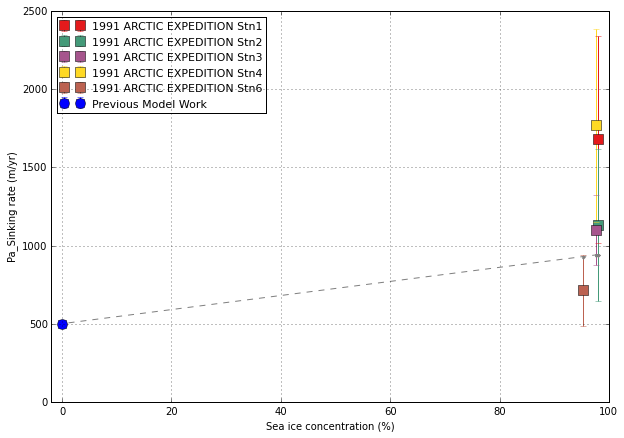

In [162]:
marker=['s','s','s','s','s','s']
#i=np.empty([5,1])
#for j in range(5):
#    data=pd.read_csv(nc_filename[j])
#    i[j,:]= data['ice'][0];
i= np.array([98,98,97.6,97.6,95.2])
    
err1=(WLS_err1/WLS_coef1)*1/WLS_coef1*0.00246
#((WLS_err1/WLS_coef1)**2)**(0.5)
sinking_rate=np.append(sinking_rate,500)
i=np.append(i,0)
err1=np.append(err1,0.01)
i2 = sm.add_constant(i,prepend=False)
mod_wls3 = sm.WLS(sinking_rate,i2,weights=1./err1**4) #Is it the real error?
res_wls3 = mod_wls3.fit()

fig, ax = plt.subplots(1,figsize=(10,7))
ax.plot(i, res_wls3.fittedvalues, '--.',color='grey')
for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    name= data['name'][0];
    errorbar(i[j],sinking_rate[j],yerr=err1[j],fmt=marker[j],markersize=10,c=cm.Set1(j*50),label=name)

ax.errorbar(i[-1],sinking_rate[-1], yerr=err1[-1], fmt='o',markersize=10,c='blue',label='Previous Model Work')
ax.legend(loc=0, fontsize=11)#,bbox_to_anchor=(1.45,1))
plt.xlabel('Sea ice concentration (%)')
plt.ylabel('Pa_Sinking rate (m/yr)')

#ax.set_ylim([0, 5000])
ax.set_xlim([-2, 100])
plt.grid()
plt.show()

In [163]:
print res_wls3.summary()

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.808
Model:                            WLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     16.85
Date:                Fri, 10 Jul 2015   Prob (F-statistic):             0.0148
Time:                        15:45:40   Log-Likelihood:                 27.636
No. Observations:                   6   AIC:                            -51.27
Df Residuals:                       4   BIC:                            -51.69
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             4.5107      1.099      4.105      0.015         1.460     7.562
const        500.0000   2.96e-07   1.69e+09      0.0

In [164]:
from statsmodels.formula.api import wls
from scipy.stats import f as scist
data = pd.DataFrame({'sinking_rate':sinking_rate, 'i3': i})
res_wls5 = wls('sinking_rate~i3', data,weights=1./(err1**4)).fit()
#test whether this fit is the same as the previous one
#print(res_wls5.summary()) 

In [165]:
a=average(sinking_rate)
rss=(sinking_rate-a)**2/err1**4
rss_sum=sum(rss)
p1 = 1
p2 = 2
n = file_num
F = (rss_sum - np.sum(res_wls5.resid**2/err1**4))/(np.sum(res_wls5.resid**2/err1**4)) *(n-p2)/(p2-p1)
p = 1.0 - scist.cdf(F,p2-p1,n-p2)
print ('F ratio: %s'%F)
print ('df:(%s,%s)'%((p2-p1),(n-p2)))
print ('ftest:%s'%p)

F ratio: 3.60190947029e+18
df:(1,3)
ftest:0.0


# WLS: K value and the ice concentration

####(1)fit the whole formula

In [166]:
#print Kvalue
#print err2

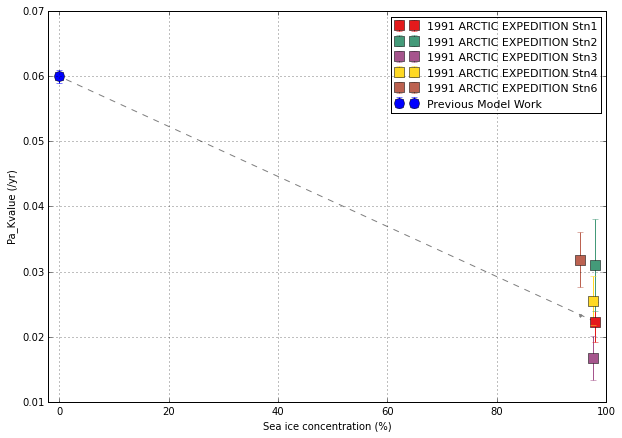

In [167]:
err2=WLS_err2/WLS_coef2*Kvalue
#err2= ((WLS_err1/WLS_coef1)+(WLS_err2/WLS_coef2))* WLS_coef1/WLS_coef2# error of k value K-1=1
#(WLS_coef1**(-4)*(WLS_coef2**(-2))*(WLS_err1)**2+WLS_coef2**(-4)*(WLS_coef1**(-2))*(WLS_err2)**2)**(0.5)
#((WLS_err1/WLS_coef1)**2+(WLS_err2/WLS_coef2)**2)**(0.5) # error of k value K-1=1

Kvalue=numpy.append(Kvalue,0.06)#0.06
err2=numpy.append(err2,0.001)

mod_wls4 = sm.WLS(Kvalue, i2, weights=1./(err2**4))
res_wls4 = mod_wls4.fit()

fig, ax = plt.subplots(1,figsize=(10,7))
ax.plot(i, res_wls4.fittedvalues,  '--.',color='grey')
for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    name= data['name'][0];
    errorbar(i[j],Kvalue[j],yerr=err2[j],fmt=marker[j],markersize=10,c=cm.Set1(j*50),label=name)
errorbar(i[-1],Kvalue[-1], yerr=err2[-1], fmt='o',markersize=10,c='blue',label='Previous Model Work')
ax.legend(loc=0,fontsize=11)
plt.xlabel('Sea ice concentration (%)')
plt.ylabel('Pa_Kvalue (/yr)')
ax.set_xlim([-2, 100])
plt.grid()
plt.show()

In [168]:
print res_wls4.summary()

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            WLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     267.6
Date:                Fri, 10 Jul 2015   Prob (F-statistic):           8.17e-05
Time:                        15:45:41   Log-Likelihood:                -42.727
No. Observations:                   6   AIC:                             89.45
Df Residuals:                       4   BIC:                             89.04
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.0004   2.35e-05    -16.358      0.000        -0.000    -0.000
const          0.0600      0.000    163.558      0.0

In [169]:
from statsmodels.formula.api import wls
from scipy.stats import f as scist
data = pd.DataFrame({'Kvalue':Kvalue, 'i3': i})
mod_wls6 = wls('Kvalue~i3', data,weights=1./(err2**4))
res_wls6 = mod_wls6.fit()
#print res_wls6.summary()

b=average(Kvalue)
print ('average k:%s'%b)
rss2=(Kvalue-b)**2/(err2**4)
rss2_sum=sum(rss2)

p1 = 1
p2 = 2
n = file_num
F = (rss2_sum - np.sum(res_wls6.resid**2/err2**4))/(np.sum(res_wls6.resid**2/err2**4)) *(n-p2)/(p2-p1)
p = 1.0 - scist.cdf(F,p2-p1,n-p2)
print ('df:(%s,%s)'%((p2-p1),(n-p2)))
print ('F ratio: %s'%F)
print ('pvalue:%s'%p)


average k:0.0312291355038
df:(1,3)
F ratio: 4624.50923774
pvalue:7.00703506895e-06


# Map

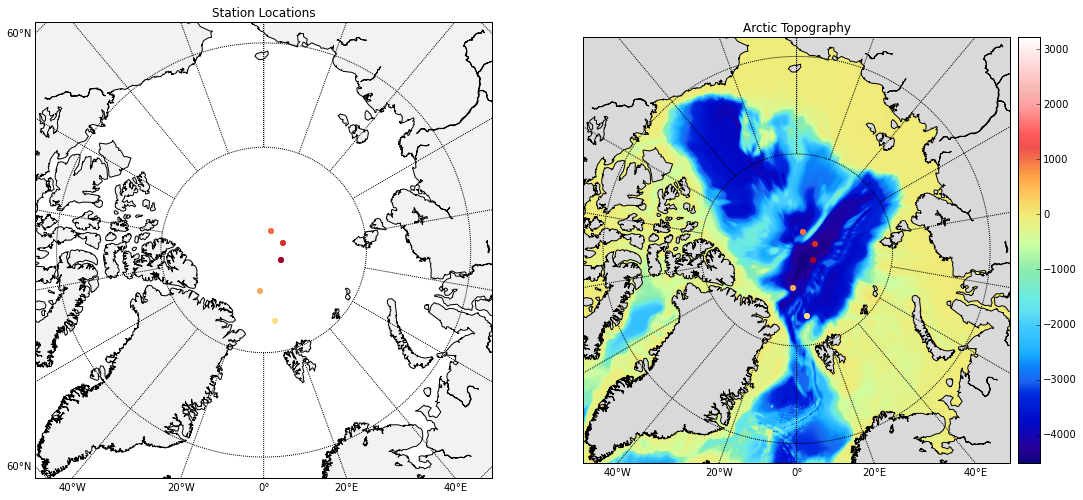

In [170]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(121)

# create Basemap instance.
m = Basemap(projection='npstere',boundinglat=68,lon_0=0,resolution='l')
for j in range(5):
    data=pd.read_csv(nc_filename[j])
    lon = data['long.'];
    lat = data['lat.'];
    x,y = m(lon.values,lat.values)
    m.scatter(x,y,color=cm.RdYlGn(j*25))
    
plt.title("Station Locations")
m.drawcoastlines()
m.fillcontinents(color = '0.95')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])

ax = fig.add_subplot(122)
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo5.nc'
etopodata = Dataset(url)

topoin = etopodata.variables['ROSE'][:]
lons = etopodata.variables['ETOPO05_X'][:]
lats = etopodata.variables['ETOPO05_Y'][:]
# shift data so lons go from -180 to 180 instead of 20 to 380.
topoin,lons = shiftgrid(180.,topoin,lons,start=False)
m = Basemap(projection='npstere',boundinglat=68,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.85')
m.drawparallels(np.arange(-80.,81.,15.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])

for j in range(5):
    data=pd.read_csv(nc_filename[j])
    lon = data['long.'];
    lat = data['lat.'];
    x,y = m(lon.values,lat.values)
    m.scatter(x,y,color=cm.RdYlGn(j*25))

nx = int((m.xmax-m.xmin)/5000.)+1; ny = int((m.ymax-m.ymin)/5000.)+1
topodat = m.transform_scalar(topoin,lons,lats,nx,ny)    
from mpl_toolkits.basemap import cm    
im = m.imshow(topodat,cm.GMT_haxby)
cb = m.colorbar(im,"right", size="5%", pad='2%')
plt.title("Arctic Topography")
plt.show()